### 1/17 追記
AutoEncoderとベイズを比較して、
`predicted image`と`p(P|Q)`の値がほぼ等しい結果が得られた.

それは一体なぜなのか考察してください.


また、この2つの間の違いを定量的に評価することは、発表の上で非常に重要な要素になりそうだと考えられます.
質よりも量で思いついた事、新しい知見などはお互い共有しよう. 何もアウトプットしないことだけは避けてほしいです.


橋爪さんからのアドバイスは以下の3つ.
- `predicted image with binalization`から`original image`に変換出来るか確認する
- `4x4MatrixGenerator.ipynb`のフィルター**A**の値を工夫する. 具体的には、より現実に近いケースを考える. 例として正規分布に従ったノイズ$\epsilon$を加えてみたり... (要考察)
- 実際の風景画や、大きなサイズにおいてこのアルゴリズムを適用してみる. ファミコンのドット絵とか面白そう? もしRGBに対応させるにはどうするか？　要考察

In [246]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as iter
import tensorflow as tf

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from PIL import Image

%matplotlib inline

In [277]:
class AE():
    def __init__(self, optimizer='rmsprop', loss='mean_squared_error', input_data_path="../4x4matrix.csv"):
        self.p_matrix = np.load("4x4matrix.npz")["p_matrix"]
        self.q_matrix = np.load("4x4matrix.npz")["q_matrix"]
        self.optimizer = optimizer
        self.model = Sequential()
        self.model.add( Dense(25, activation = 'relu', input_dim = 9) )
        #self.model.add( Dense(16, activation = 'relu') )
        self.model.add( Dense(16, activation = 'hard_sigmoid') )
        #self.model.add( Dense(16, activation = keras.layers.ReLU(max_value=1, negative_slope=0, threshold = 0)) )
        #self.model.add( Dense(16, activation = keras.layers.ReLU(max_value=1, negative_slope=0, threshold = 0)) )
        self.model.compile(optimizer = optimizer,
                           loss = loss,
                           metrics = ['accuracy'])
        
    def fit(self, epochs='4', batch_size='256'):
        self.model.fit(self.q_matrix, self.p_matrix,
                      epochs = epochs,
                      batch_size = batch_size,
                      validation_data = (self.q_matrix, self.p_matrix))
    
    def predict(self, test_img, threshold):
        self.preds = self.model.predict(test_img).reshape(4,4)
        self.preds_binary = self.preds.copy()
        self.preds_binary[self.preds_binary < threshold] = 0
        self.preds_binary[self.preds_binary >= threshold] = 1
        print(self.preds, self.preds_binary)
        
        if test_img.dtype == 'int64':
            ncols = 5
            fig, axes = plt.subplots(nrows = 1, ncols = ncols, figsize = (14,14))
            bayes_image = np.empty(16)
            index_when_given_q = np.all(self.q_matrix == test_img, axis = 1)
            p_given_q = self.p_matrix[index_when_given_q]
            for i in range(16):
                is_one_counter = 0
                target_list = [p_given_q[j][i] for j in range(p_given_q.shape[0])]
                total_length = len(target_list)
    
                for j in range(total_length):
                    if target_list[j] == 1:
                        is_one_counter += 1
                prob = is_one_counter / total_length
                bayes_image[i] = prob
            axes[3].imshow(bayes_image.reshape(4,4), cmap = plt.cm.binary)
            axes[3].set_title("p(P|Q) image based on bayes")
            bayes_image[ bayes_image < thresold ] = 0
            bayes_image[ bayes_image >= thresold ] = 1
            axes[4].imshow(bayes_image.reshape(4,4), cmap = plt.cm.binary)
            axes[4].set_title("p(P|Q) image based on bayes with binalization")
            
        elif test_img.dtype == 'float64':
            ncols = 3
            fig, axes = plt.subplots(nrows = 1, ncols = ncols, figsize = (14,14))
        

        axes[0].imshow(test_img.reshape(3,3), cmap = plt.cm.binary)
        axes[0].set_title("original image")
        axes[1].imshow(self.preds, cmap = plt.cm.binary)
        axes[1].set_title("predicted image")
        axes[2].imshow(self.preds_binary, cmap = plt.cm.binary)
        axes[2].set_title("predicted image with binalization")
        
    def SR(self, input_img, thresold):
        # Preprocessing area
        x, y, z = input_img.shape # dimention x and y
        pad_list = [] # padding count x = 0, y = 1
        for i in [x, y]:
            if i % 3 == 0:
                pad_list.append(0)
            elif i % 3 == 1:
                pad_list.append(2)
            else:
                pad_list.append(1)
        
        temp = np.zeros((x + pad_list[0], y + pad_list[1], 3), dtype='float32') # new temporary array replaced with input_img
        temp[ 0 : x, 0 : y , 0 : z] = input_img
        input_img = temp
        m,n = int(input_img.shape[0] / 3), int(input_img.shape[1] / 3)
        output_img = np.empty((4 * m , 4 * n, 3), dtype='float32')
        print(pad_list[0], pad_list[1])
        
        # SR area
        for dim in [0,1,2]:
            for i, j in iter.product(range(n), range(m)):
                partial_img = input_img.copy()[ 3 * j : 3 * ( j + 1 ), 3 * i : 3 * ( i + 1), dim] 
                partial_img = self.model.predict( partial_img.reshape(1,9) )
                output_img[4 * j : 4 * (j + 1), 4 * i : 4 * ( i + 1), dim] = partial_img.reshape(4,4)

        output_img_binalized = output_img.copy()
        output_img_binalized[output_img_binalized >= thresold] = 1
        output_img_binalized[output_img_binalized < thresold] = 0

        fig, axes = plt.subplots(1,3, figsize = (12,12))
        axes[0].imshow(input_img, cmap = plt.cm.binary)
        axes[0].set_title("input image")
        axes[1].imshow(output_img, cmap = plt.cm.binary)
        axes[1].set_title("output image")
        axes[2].imshow(output_img_binalized, cmap = plt.cm.binary)
        axes[2].set_title("output image with biinalization")

In [278]:
autoencoder = AE(optimizer = "rmsprop", loss = keras.losses.mean_squared_error)

## モデル

In [279]:
autoencoder.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 25)                250       
_________________________________________________________________
dense_62 (Dense)             (None, 16)                416       
Total params: 666
Trainable params: 666
Non-trainable params: 0
_________________________________________________________________


## 学習

In [280]:
autoencoder.fit(epochs = 3, batch_size=256)

Exception ignored in: <bound method NpzFile.__del__ of <numpy.lib.npyio.NpzFile object at 0xb4a2d4828>>
Traceback (most recent call last):
  File "/Users/shimotori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/numpy/lib/npyio.py", line 219, in __del__
    self.close()
  File "/Users/shimotori/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/numpy/lib/npyio.py", line 210, in close
    if self.zip is not None:
AttributeError: 'NpzFile' object has no attribute 'zip'


Train on 5308416 samples, validate on 5308416 samples
Epoch 1/3
5308416/5308416 [==============================] - 57s 11us/step - loss: 0.2103 - acc: 0.0536 - val_loss: 0.2097 - val_acc: 0.0482
Epoch 2/3
5308416/5308416 [==============================] - 54s 10us/step - loss: 0.2095 - acc: 0.0449 - val_loss: 0.2095 - val_acc: 0.0319
Epoch 3/3
5308416/5308416 [==============================] - 53s 10us/step - loss: 0.2094 - acc: 0.0511 - val_loss: 0.2094 - val_acc: 0.0314


## 予測

[[0.57609314 0.66188985 0.6306913  0.57262534]
 [0.6620086  0.7572051  0.7435026  0.6599936 ]
 [0.6351537  0.7654749  0.7547922  0.65544647]
 [0.6202765  0.64120215 0.6858125  0.59079206]] [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]


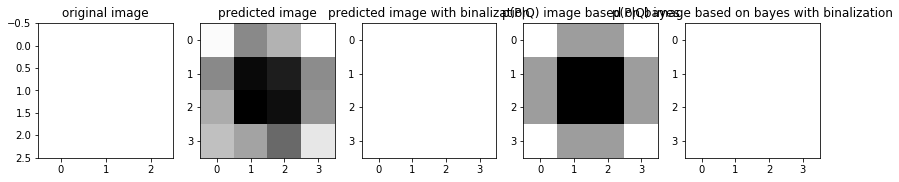

In [281]:
test_img = np.array([[1,1,1,1,1,1,1,1,1]])
threshold = 0.5
autoencoder.predict(test_img, threshold)

## より大きな画像で超解像を行う

### 仕様
- `input_img` 
    - (3 x n, 3 x m) dimention
    - from 0 to 1 
    
- `output_img`
    - (4 x n, 4 x m) dimention
    - 0 or 1 binalized
    
- `thresold`

Text(0.5, 1.0, 'output image with biinalization')

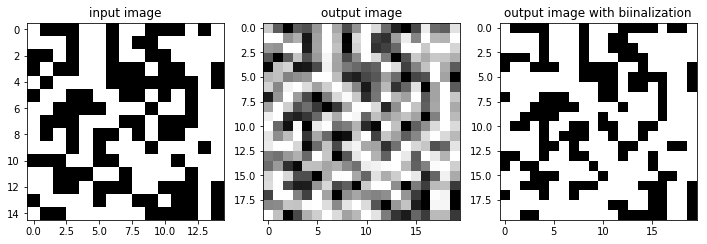

In [252]:
# n = 4
# m = 4
thresold = 0.5

input_img = np.random.randint(0, 2, (15,15), dtype='int64')
x, y = input_img.shape
n, m = int( x / 3 ), int( y / 3 )
output_img = np.empty((4 * n , 4 * m), dtype='float64')

for i, j in iter.product(range(n), range(m)):
    partial_img = input_img.copy()[ 3 * j : 3 * (j + 1), 3 * i : 3 * ( i + 1)] 
    partial_img = autoencoder.model.predict(partial_img.reshape(1,9))
    output_img[4 * j : 4 * (j + 1), 4 * i : 4 * ( i + 1)] = partial_img.reshape(4,4)

output_img_binalized = output_img.copy()
output_img_binalized[output_img_binalized >= thresold] = 1
output_img_binalized[output_img_binalized < thresold] = 0

fig, axes = plt.subplots(1,3, figsize = (12,12))
axes[0].imshow(input_img, cmap = plt.cm.binary)
axes[0].set_title("input image")
axes[1].imshow(output_img, cmap = plt.cm.binary)
axes[1].set_title("output image")
axes[2].imshow(output_img_binalized, cmap = plt.cm.binary)
axes[2].set_title("output image with biinalization")

## メソッド版
`img1.jpeg`
`img2.jpeg`

0 0


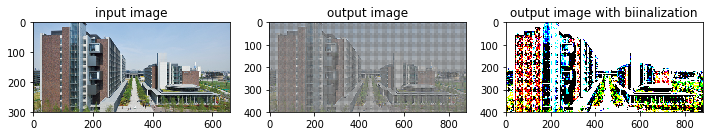

In [283]:
#input_img = np.random.randint(0,2, (15,15), dtype='int16')
input_img = np.array(Image.open("img/img3.jpg"), "f")/255
autoencoder.SR(input_img, 0.5)

## ベイズルールによる結果

In [7]:
index_when_given_q = np.all(autoencoder.q_matrix == test_img, axis = 1)
p_given_q = autoencoder.p_matrix[index_when_given_q]

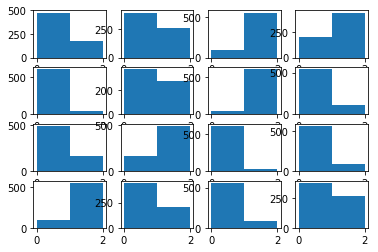

In [8]:
n = 16
for i in range(n):
    ax = plt.subplot(4, 4, i+1)
    plt.hist([p_given_q[j][i] for j in range(p_given_q.shape[0])], bins = [0,1,2])

In [9]:
n = 16
bayes_image = np.empty(n)
for i in range(n):
    is_one_counter = 0
    target_list = [p_given_q[j][i] for j in range(p_given_q.shape[0])]
    total_length = len(target_list)
    
    for j in range(total_length):
        if target_list[j] == 1:
            is_one_counter += 1
    prob = is_one_counter / total_length
    bayes_image[i] = prob

In [10]:
bayes_image

array([0.2654321 , 0.39969136, 0.85339506, 0.6867284 , 0.06018519,
       0.42283951, 0.92592593, 0.16820988, 0.25154321, 0.74845679,
       0.05092593, 0.13117284, 0.85802469, 0.3117284 , 0.13580247,
       0.41049383])

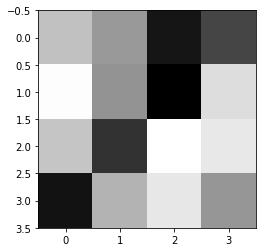

In [11]:
plt.imshow(bayes_image.reshape(4,4), cmap = plt.cm.binary)

In [198]:
test = np.random.randint(0,2,(6,4))
x, y = test.shape
xy = 0 #count x = 0, y = 1
pad_list = []
for i in [x, y]:
    if i % 3 == 0:
        pad_list.append(0)
    elif i % 3 == 1:
        pad_list.append(2)
    else:
        pad_list.append(1)
    xy += 1

test_ = np.zeros((x + pad_list[0], y + pad_list[1]))
print(test_.shape)

(6, 6)


In [186]:
for i in [x, y]:
    print(i)

6
4
